In [1]:
import numpy as np

In [2]:
from scipy.io import loadmat

train = loadmat('/Users/enea/Downloads/tidigits_mfccs_train.mat')['tidigits_mfccs_train']
test = loadmat('/Users/enea/Downloads/tidigits_mfccs_test.mat')['tidigits_mfccs_test']

In [3]:
sampTr = train['mfccs_third'][0][0][0] 
labTr = train['idx_labels'][0][0]
sampTe = test['mfccs_third'][0][0][0]
labTe = test['idx_labels'][0][0]

In [4]:
#find max length sample to use it as reference for padding
maxlenTr= 0
maxlenTe= 0
for i in range(sampTr.shape[0]):
    if sampTr[i].shape[1]>maxlenTr:
        maxlenTr = sampTr[i].shape[1]
        indexTr = i
        
for i in range(sampTe.shape[0]):
    if sampTe[i].shape[1]>maxlenTe:
        maxlenTe = sampTe[i].shape[1]
        indexTe = i
        
if maxlenTe>maxlenTr:
    maxl=maxlenTe
else:
    maxl=maxlenTr
    

In [5]:
#pad out all training and test samples
trainObs=np.zeros([sampTr.shape[0],maxl,sampTr[0].shape[0]])
testObs=np.zeros([sampTe.shape[0],maxl,sampTe[0].shape[0]])

for i in range(sampTr.shape[0]):
    s = sampTr[i].shape
    trainObs[i] = np.concatenate((np.zeros((39, maxl - s[1])), sampTr[i]), axis=1).T
        
for i in range(sampTe.shape[0]):
    s = sampTe[i].shape
    testObs[i] = np.concatenate((np.zeros((39, maxl - s[1])), sampTe[i]), axis=1).T
    

              

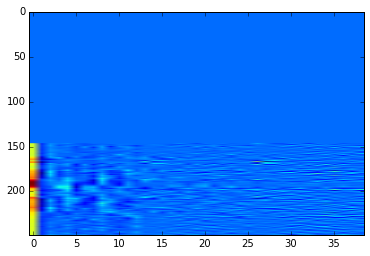

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure
plt.imshow(np.squeeze(testObs[10]), aspect='auto')

In [7]:
#convert class labels from scalars to one-hot vectors
def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [8]:
labelsTr = dense_to_one_hot(labTr[0],num_classes=11)
labelsTe = dense_to_one_hot(labTe[0],num_classes=11)

In [9]:
#shuffle data
p = np.random.permutation(trainObs.shape[0])
a = np.zeros_like(trainObs)
a = trainObs[p,:,:]
b = np.zeros_like(labelsTr)
b = labelsTr[p,:]
trainObs = a
labelsTr = b

p = np.random.permutation(testObs.shape[0])
a = np.zeros_like(testObs)
a = testObs[p,:,:]
b = np.zeros_like(labelsTe)
b = labelsTe[p,:]
testObs = a
labelsTe = b

In [10]:
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell,BasicLSTMCell
from tensorflow.python.ops import rnn

In [11]:
tf.reset_default_graph()

learning_rate = 0.001
training_iters = 500
batch_size = 100
display_step = 40

n_input = 39
n_steps = maxl
n_hidden = 128
n_classes = 11

x = tf.placeholder('float',[None, n_steps, n_input])
y = tf.placeholder('float',[None, n_classes])

In [12]:
def RNN(x):
    layer = {'weights':tf.Variable(tf.random_normal([n_hidden,n_classes])),
             'biases':tf.Variable(tf.random_normal([n_classes]))}
    cell = LSTMCell(n_hidden,state_is_tuple=True)
    cell = MultiRNNCell([cell] * 2)
    output, states = rnn.dynamic_rnn(cell, x, dtype = tf.float32)
    output = tf.transpose(output, [1, 0, 2])
    last = tf.gather(output, int(output.get_shape()[0]) - 1)

    output = tf.matmul(last,layer['weights'])+layer['biases']
    
    return output

In [13]:
prediction =RNN(x)

# define cost and optimizer
cost= tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
#evaluate model
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, 'float'))


/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [17]:
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    
    for itr in range(training_iters):
        offset = (itr * batch_size) % (labelsTr.shape[0] - batch_size)
        batch_x = trainObs[offset:(offset + batch_size),:,:]
        batch_y = labelsTr[offset:(offset + batch_size), :]
        _, c = session.run([optimizer, cost],feed_dict={x: batch_x, y : batch_y})
           
        if itr % display_step == 0:
            # Calculate batch accuracy
            acc = session.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(itr) + ", Training Accuracy= " + "{:.5f}".format(acc))
            acc = session.run(accuracy, feed_dict={x: testObs, y: labelsTe})
            print("Test Accuracy= " + "{:.5f}".format(acc))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Instructions for updating:
Use `tf.global_variables_initializer` instead.


Iter 0, Training Accuracy= 0.09000
Test Accuracy= 0.09815
Iter 40, Training Accuracy= 0.37000
Test Accuracy= 0.31175
Iter 80, Training Accuracy= 0.67000
Test Accuracy= 0.65567
Iter 120, Training Accuracy= 0.93000
Test Accuracy= 0.79525
Iter 160, Training Accuracy= 0.97000
Test Accuracy= 0.83307
Iter 200, Training Accuracy= 0.98000
Test Accuracy= 0.86082
Iter 240, Training Accuracy= 0.99000
Test Accuracy= 0.84916
Iter 280, Training Accuracy= 1.00000
Test Accuracy= 0.87289
Iter 320, Training Accuracy= 1.00000
Test Accuracy= 0.90265
Iter 360, Training Accuracy= 1.00000
Test Accuracy= 0.88898
Iter 400, Training Accuracy= 1.00000
Test Accuracy= 0.90869
Iter 440, Training Accuracy= 1.00000
Test Accuracy= 0.91231
Iter 480, Training Accuracy= 1.00000
Test Accuracy= 0.92599


In [ ]:
print trainObs.shape

In [16]:
acc = tf.Session().run(accuracy, feed_dict={x: testObs, y: labelsTe})

FailedPreconditionError: Attempting to use uninitialized value rnn/multi_rnn_cell/cell_1/lstm_cell/biases
	 [[Node: rnn/multi_rnn_cell/cell_1/lstm_cell/biases/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](rnn/multi_rnn_cell/cell_1/lstm_cell/biases)]]

Caused by op u'rnn/multi_rnn_cell/cell_1/lstm_cell/biases/read', defined at:
  File "/Users/enea/anaconda/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/enea/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/enea/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/enea/anaconda/lib/python2.7/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/Users/enea/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 389, in start
    ioloop.IOLoop.instance().start()
  File "/Users/enea/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/Users/enea/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 465, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 407, in _run_callback
    callback(*args, **kwargs)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 252, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 213, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 362, in execute_request
    user_expressions, allow_stdin)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/enea/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-8823806d5124>", line 1, in <module>
    prediction =RNN(x)
  File "<ipython-input-12-6ea5b305df9e>", line 6, in RNN
    output, states = rnn.dynamic_rnn(cell, x, dtype = tf.float32)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 545, in dynamic_rnn
    dtype=dtype)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 712, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2626, in while_loop
    result = context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2459, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2409, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 697, in _time_step
    (output, new_state) = call_cell()
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 683, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 655, in __call__
    cur_inp, new_state = cell(cur_inp, cur_state)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 338, in __call__
    scope=scope)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 759, in _linear
    initializer=init_ops.constant_initializer(bias_start, dtype=dtype))
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 988, in get_variable
    custom_getter=custom_getter)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 890, in get_variable
    custom_getter=custom_getter)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 348, in get_variable
    validate_shape=validate_shape)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 333, in _true_getter
    caching_device=caching_device, validate_shape=validate_shape)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 684, in _get_single_variable
    validate_shape=validate_shape)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 226, in __init__
    expected_shape=expected_shape)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 341, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1490, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/enea/anaconda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value rnn/multi_rnn_cell/cell_1/lstm_cell/biases
	 [[Node: rnn/multi_rnn_cell/cell_1/lstm_cell/biases/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](rnn/multi_rnn_cell/cell_1/lstm_cell/biases)]]
